In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import matplotlib.pyplot as plt

In [6]:
df_all = pd.read_csv("~/python_project/data/AI_p_dataset/data_by_all_20230514.csv")
df_states = pd.read_csv("~/python_project/data/AI_p_dataset/data_by_states_20230514.csv")

In [7]:
# ID를 기준으로 dataframe 머지.
df = pd.merge(df_states, df_all, on='ID')

In [8]:
# 작물이름에 따라 groupby
grouped = df.groupby('crop')

group_dict = {}  # 그룹을 저장할 딕셔너리

for group_id, group_df in grouped:
		if group_id != 'Wheat':
				# 아래 column들 삭제 및 column 명 변경
				group_df = group_df.drop(
						['productions_winter', 'harvested_winter', 'cultivated_winter'], axis=1)
				group_df = group_df.rename(
						columns={'productions_spring': 'productions', 'harvested_spring': 'harvested', 'cultivated_spring': 'cultivated'})
				
				# 결측치 있는 행 삭제
				group_df = group_df.dropna()
				group_dict[group_id] = group_df
		else:
				# productions_spring 열과 productions_winter 열이 모두 빈 행 삭제
				group_df = group_df.dropna(
						subset=['productions_spring', 'productions_winter'], how='all')
				
				# 겨울철 밀 데이터
				winter = group_df.copy()
				winter = winter.drop(
						['productions_spring', 'harvested_spring', 'cultivated_spring'], axis=1)
				winter = winter.rename(
                                    columns={'productions_winter': 'productions', 'harvested_winter': 'harvested', 'cultivated_winter': 'cultivated'})
				
				# 봄철 밀 데이터
				spring = group_df.copy()
				spring = spring.drop(
						['productions_winter', 'harvested_winter', 'cultivated_winter'], axis=1)
				spring = spring.rename(
						columns={'productions_spring': 'productions', 'harvested_spring': 'harvested', 'cultivated_spring': 'cultivated'})
				
				winter.dropna()
				spring.dropna()
				group_dict['Winter_wheat'] = winter
				group_dict['Spring_wheat'] = spring

In [11]:
data_corn = group_dict['Corn'].drop(['crop'], axis=1)

# date column의 연도(yyyy) 값 추출
data_corn['year-state'] = data_corn['ID'].str[:4] + data_corn['state']

# 각 'target' 값에 대응하는 'X' 값을 저장하기 위한 딕셔너리 생성
X_dict = defaultdict(list)
for _, row in data_corn.iterrows():
    X = row.drop(['ID', 'productions', 'year-state', 'state']).tolist()
    year_state = row['year-state']
    X_dict[year_state].append(X)

In [14]:
#data_corn['year-state']의 값 중 unique한 값에 대해서만 해당 data를 X에 추가
X = [X_dict[year_state] for year_state in np.unique(data_corn['year-state'])]

#X를 [batch_size, feature_size]로 변경
X = np.array(X).reshape(len(X), -1)

In [29]:
#data_corn['year-state']의 값 중 unique한 값에 대해서만 production 값을 y에 추가, 12개 값이 다 같으므로 그냥 첫번째거 추가함
y = [data_corn[data_corn['year-state'] == year_state]["productions"].values[0] for year_state in np.unique(data_corn['year-state'])]

In [35]:
#decision tree나 random forest는 normalize를 할 필요가 없는 모델이기 때문에 그 부분은 생략함
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [78]:
#regression셋에 대한 Random Forest 선언 (사용된 트리의 개수 = 200)
reg = RandomForestRegressor(n_estimators = 200, max_features = 'sqrt')

#Random Forest 학습
reg.fit(X_train, y_train)

#testset에 대한 예측값을 바탕으로 RMSE계산
y_pred = reg.predict(X_test)
RMSE = mean_squared_error(y_test, y_pred) ** 0.5
print(RMSE)    

5552375.915135589


In [113]:
feature_importance = reg.feature_importances_
col_name_of_X = data_corn.drop(columns = ['ID', 'productions',
                                            'year-state', 'state']).columns.tolist()
col_name_with_month = []
for i in range(1, 13):
    for entry in col_name_of_X:
        if i <10:
            col_name_with_month.append(entry + "_0" + str(i))
        else:
            col_name_with_month.append(entry + "_" + str(i))

In [120]:
#전체 feature의 feature importance를 bar graph로 그람
plt.figure(figsize=(160, 180))
plt.barh(np.arange(X.shape[1]), feature_importance, align = 'center')
plt.yticks(np.arange(X.shape[1]), columnname_with_month, fontsize=35)
plt.xlabel('feature_importance', size = 60)
plt.ylabel('feature', size = 60)
plt.show()
plt.savefig("feature_importance_bar.png")

<Figure size 432x288 with 0 Axes>

In [129]:
#feature importance가 높은 순서대로 k개를 선택
topk = 36
feature_importance_topk = [feature_importance[i] for i in np.argsort(feature_importance)[-topk:]]
feature_importance_topk_col_name = [col_name_with_month[i] for i in np.argsort(feature_importance)[-topk:]]

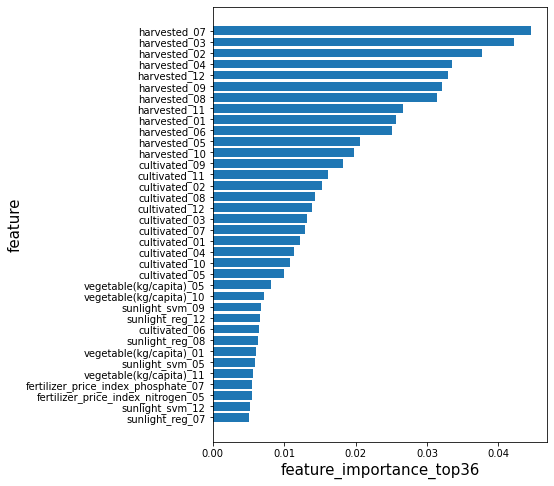

<Figure size 432x288 with 0 Axes>

In [130]:
#feature_importance가 높은 k개에 대해 bar graph 그림
plt.figure(figsize=(6, 8))
plt.barh(np.arange(topk), feature_importance_topk, align = 'center')
plt.yticks(np.arange(topk), feature_importance_topk_col_name, fontsize=10)
plt.xlabel('feature_importance_top' + str(topk), size = 15)
plt.ylabel('feature', size = 15)
plt.show()
plt.savefig("topk_feature_importance_bar.png")